<h1><center>Programming Exercise 6:<br>Support Vector Machines</center></h1>

In [30]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import svm
import L67Data
from numpy import linalg as LA

mpl.rcParams['figure.figsize'] = (10,6)

# 1. Support Vector Machines
- Use SVMs with various example 2D dataset

## 1.1 Examples Dataset 1
- The data in `ex6data1.mat` can be separated by a linear boundary. The positions of the positive examples (+) and the negative examples (o) suggest a natural separation indicated by the gap. However, there is an outlier positive example on the far left at about (0.1,0.4). We will see how this outlier affects the SVM decision boundary

In [5]:
data1 = loadmat('ex6data1.mat')
X = data1['X'] # no need to add the bias terms, the svm object does it internally
y = data1['y'].flatten() # output labels

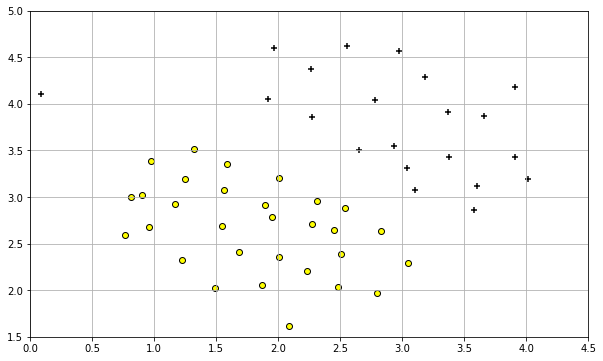

In [7]:
plt.figure()
plt.grid(True)
plt.scatter(X[:,0][y==1],X[:,1][y==1],marker='+',edgecolors='k',facecolor='k')
plt.scatter(X[:,0][y==0],X[:,1][y==0],marker='o',edgecolors='k',facecolor='yellow')
plt.xlim(0,4.5)
plt.ylim(1.5,5)
plt.xlabel(r'$x_1$',fontsize=14)
plt.ylabel(r'$x_2$',fontsize=14)
plt.show()

- Try different values of the $C$ parameter with SVMs
- Informally $C$ is a positive value that controls the penalty for misclassified training examples. A large $C$ parameters tells the SVM to try to classify all examples correctly. $C$ plays a role similar to $1/\lambda$, the reg. parameter for logistic regression
- Train the SVM with both $C=1$ and $C=100$
- We use an SVM from the sklearn library

In [8]:
svc = svm.SVC(C=1.0,kernel='linear') # initialize linear SVM instance

In [9]:
svc.fit(X,y) # train classifier

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

- Perform prediction over grid:

In [10]:
# Create a mesh to plot in
h = .02  # Step size in the mesh
x_min, x_max = 0, 4.5
y_min, y_max = 1.5, 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
# Plot the decision boundary. For that, we will assign a color to each point in the mesh
z_svc = svc.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
z_svc = z_svc.reshape(xx.shape)

- Plot over mesh but first make a custom colormap since we want to plot the two classes as either yellow ($y=0$) or black ($y=1$)

In [21]:
yellow_black = L67Data.make_colormap(['yellow','k'])

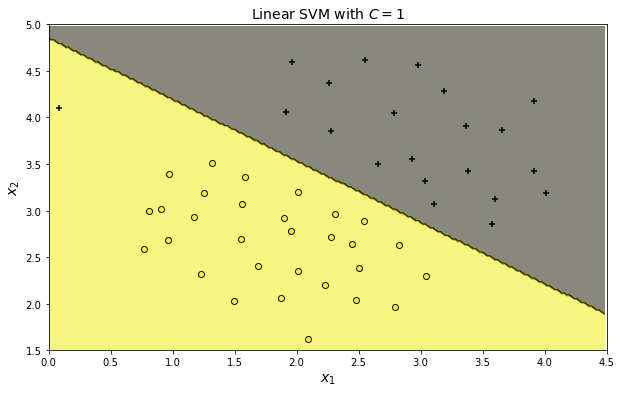

In [25]:
plt.figure()
#cs = plt.contour(xx,yy,z_svc,levels=[0],colors='b',linestyles='-',linewidths=2) # explicitly plot decision boundary
# plt.clabel(cs, fmt = '%2.1d', colors = 'b', fontsize=14) # label decision boundary contour line
csf = plt.contourf(xx,yy,z_svc,cmap=yellow_black,alpha=0.5) # classified feature space
#plt.colorbar(csf)
plt.scatter(X[:,0][y==1],X[:,1][y==1],marker='+',edgecolors='k',facecolor='k')
plt.scatter(X[:,0][y==0],X[:,1][y==0],marker='o',edgecolors='k',facecolor='yellow')
plt.xlim(0,4.5)
plt.ylim(1.5,5)
plt.xlabel(r'$x_1$',fontsize=14)
plt.ylabel(r'$x_2$',fontsize=14)
plt.title(r'Linear SVM with $C=1$',fontsize=14)
plt.show()

- As we can see, this corresponds to somewhat of an "underfit" i.e the + point around (0.1,0.4) is not classified correctly. This is expected since $C$ is small
- Now let's try $C=100$:

In [27]:
svc = svm.SVC(C=100.0,kernel='linear') 
svc.fit(X,y)

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [28]:
# Plot the decision boundary. For that, we will assign a color to each point in the mesh
z_svc = svc.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
z_svc = z_svc.reshape(xx.shape)

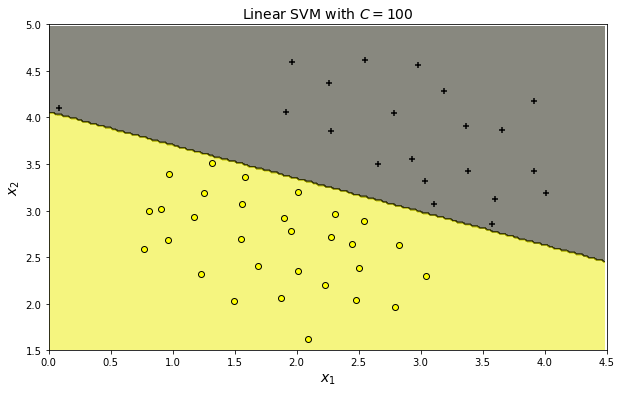

In [29]:
plt.figure()
#cs = plt.contour(xx,yy,z_svc,levels=[0],colors='b',linestyles='-',linewidths=2) # explicitly plot decision boundary
# plt.clabel(cs, fmt = '%2.1d', colors = 'b', fontsize=14) # label decision boundary contour line
csf = plt.contourf(xx,yy,z_svc,cmap=yellow_black,alpha=0.5) # classified feature space
#plt.colorbar(csf)
plt.scatter(X[:,0][y==1],X[:,1][y==1],marker='+',edgecolors='k',facecolor='k')
plt.scatter(X[:,0][y==0],X[:,1][y==0],marker='o',edgecolors='k',facecolor='yellow')
plt.xlim(0,4.5)
plt.ylim(1.5,5)
plt.xlabel(r'$x_1$',fontsize=14)
plt.ylabel(r'$x_2$',fontsize=14)
plt.title(r'Linear SVM with $C=100$',fontsize=14)
plt.show()

- Now the SVM classifies every single example correctly but the decision boundary that does not appear to be a natural fit for the data. A more "overfit" classification is expected since $C$ is larger

## 1.2 SVM with Gaussian Kernels
- Use SVMs with Gaussian kernels to do non-linear classification on datasets that are not linearly separable
- We'll train using sklearn.svm.SVC's Gaussian kernel later on but we'll build the Gaussian kernel function anyways and test the parameters they give in ex6.m
- Recall that the Gaussian kernel function is degined as:

$$
K_{\text{gaussian}}(x^{(i)},x^{(j)})=\exp\left(-\frac{\lVert x^{(i)}-x^{(j)}\rVert^2}{2\sigma^2}\right) = \exp\left(-\frac{\sum_{k=1}^n(x^{(i)}-x^{(j)})^2}{2\sigma^2}\right)
$$

In [36]:
def similarity(x1,x2,sigma):
    '''
    Returns a radial basis function kernel between samples x1 and x2
    
    Parameters
    ------------
    x1 (1D arr): first sample n-dimensional vector
    x2 (1D arr): second sample n-dimensional vector
    
    Returns
    ------------
    sim (float): similarity function value at vectors x1 and x2
    '''
    
    sim = np.exp(-LA.norm(x1-x2)**2/(2*sigma**2))
    return sim

- Test it:

In [38]:
x1 = np.array([1,2,1])
x2 = np.array([0,4,-1])
sigma = 2
similarity(x1,x2,sigma) # should be = 0.324652

0.32465246735834974

- The following dataset is not linearly separable. Let's load it and plot it:

In [41]:
data2 = loadmat('ex6data2.mat')
X = data2['X'] # no need to add the bias terms, the svm object does it internally
y = data2['y'].flatten() # output labels

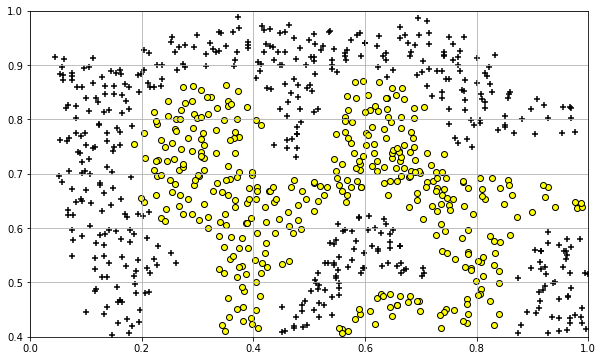

In [42]:
plt.figure()
plt.grid(True)
plt.scatter(X[:,0][y==1],X[:,1][y==1],marker='+',edgecolors='k',facecolor='k')
plt.scatter(X[:,0][y==0],X[:,1][y==0],marker='o',edgecolors='k',facecolor='yellow')
plt.xlim(0,1)
plt.ylim(0.4,1)
plt.xlabel(r'$x_1$',fontsize=14)
plt.ylabel(r'$x_2$',fontsize=14)
plt.show()

- Now we train an Gaussian-kernel SVM with $C=1$ and $\sigma=0.1$
- sklearn.svm.SVC's kernel `rbf` is the Gaussian kernel but with a slightly different definition, that is $\exp(-\gamma\lVert x-x'\rVert^2)$. Thus we relate $\sigma$ to $\gamma$ as:

$$
\gamma = \frac{1}{2\sigma^2}
$$

In [43]:
sigma = 0.1
gamma = 1/(2*sigma**2)
svc = svm.SVC(C=100.0,kernel='rbf',gamma=gamma) 
svc.fit(X,y)

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=49.99999999999999,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [46]:
# Create a mesh to plot in
h = .02  # Step size in the mesh
x_min, x_max = 0, 1.1
y_min, y_max = 0.4, 1.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
# Plot the decision boundary. For that, we will assign a color to each point in the mesh
z_svc = svc.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
z_svc = z_svc.reshape(xx.shape)

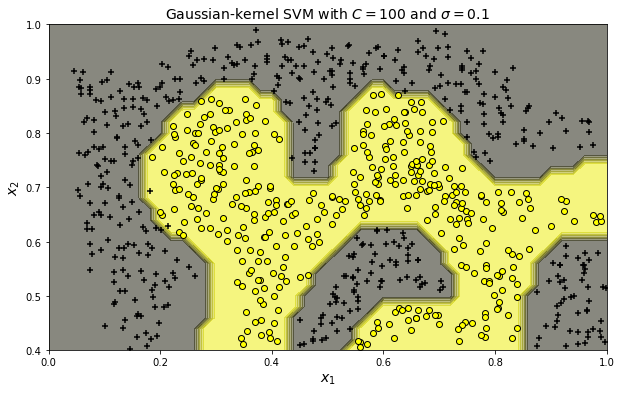

In [49]:
plt.figure()
#cs = plt.contour(xx,yy,z_svc,levels=[0],colors='b',linestyles='-',linewidths=2) # explicitly plot decision boundary
# plt.clabel(cs, fmt = '%2.1d', colors = 'b', fontsize=14) # label decision boundary contour line
csf = plt.contourf(xx,yy,z_svc,cmap=yellow_black,alpha=0.5) # classified feature space
#plt.colorbar(csf)
plt.scatter(X[:,0][y==1],X[:,1][y==1],marker='+',edgecolors='k',facecolor='k')
plt.scatter(X[:,0][y==0],X[:,1][y==0],marker='o',edgecolors='k',facecolor='yellow')
plt.xlim(0,1)
plt.ylim(0.4,1)
plt.xlabel(r'$x_1$',fontsize=14)
plt.ylabel(r'$x_2$',fontsize=14)
plt.title(r'Gaussian-kernel SVM with $C=100$ and $\sigma=0.1$',fontsize=14)
plt.show()

- This decision boundary is able to separate most of the positive and negative examples correctly and follows the contours of the dataset well
- Now let's look at the next non-linearly separable set:

In [64]:
data3 = loadmat('ex6data3.mat')
X = data3['X'] # no need to add the bias terms, the svm object does it internally
y = data3['y'].flatten() # output labels
Xval = data3['Xval'] # validation set
yval = data3['yval'].flatten()

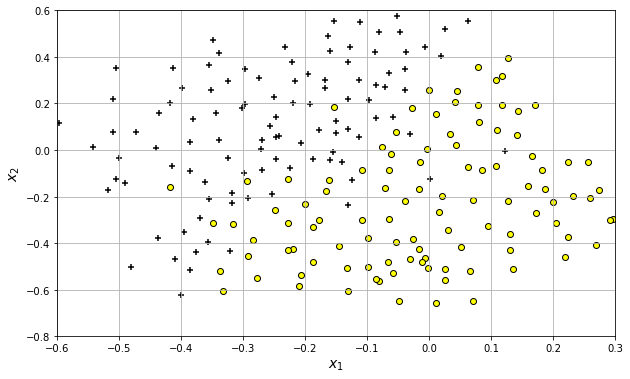

In [65]:
plt.figure()
plt.grid(True)
plt.scatter(X[:,0][y==1],X[:,1][y==1],marker='+',edgecolors='k',facecolor='k')
plt.scatter(X[:,0][y==0],X[:,1][y==0],marker='o',edgecolors='k',facecolor='yellow')
plt.xlim(-0.6,0.3)
plt.ylim(-0.8,0.6)
plt.xlabel(r'$x_1$',fontsize=14)
plt.ylabel(r'$x_2$',fontsize=14)
plt.show()

- Now we will use the cross validation set `Xval` and `yval` to determine the best $C$ and $\sigma$ parameters to use from values (0.01,0.03,0.1,0.3,1,3,10,30) for each respectively. This means we need to test $8^2=64$ total models and pick the one with the best score (accuracy)
- The easiest way to do is to perfrom a grid search over parameters using sklearn.model_selection.GridSearchCV but there is no way to explicitly pass in a validation set apart from the training set. GridSearchCV does a K-cross validation internally once given training `X` and `y`. Thus we do it manually (which is not that difficult after all)

In [80]:
c_vals = np.array([0.01,0.03,0.1,0.3,1,3,10,30])
sigma_vals = c_vals

In [81]:
best_score = 0 # initialize to zero

# Loop through params and look for best score
for ii_c in c_vals:
    for ii_sigma in sigma_vals:
            ii_gamma = 1/(2*ii_sigma**2)
            ii_svc = svm.SVC(C=ii_c,kernel='rbf',gamma=ii_gamma) # initialize SVM with params
            ii_svc.fit(X,y) # fit model to training set
            ii_score = ii_svc.score(Xval,yval) # test on cv set and get score (accuracy)
            if ii_score > best_score:
                best_score = ii_score
                optimal_C = ii_c
                optimal_sigma = ii_sigma
                optimal_gamma = ii_gamma

In [82]:
print("Best parameters set found on cv set:\n{{'C': {}, 'sigma': {}}}\n".format(optimal_C,optimal_sigma))
print("Best score with this set: {}".format(best_score))

Best parameters set found on cv set:
{'C': 1.0, 'sigma': 0.1}

Best score with this set: 0.965


- Now let's train to this optimal set and plot the classified feature space:

In [91]:
svc = svm.SVC(C=optimal_C,kernel='rbf',gamma=optimal_gamma)
svc.fit(X,y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=49.999999999999993,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [92]:
# Create a mesh to plot in
h = .02  # Step size in the mesh
x_min, x_max = -0.6, 0.3
y_min, y_max = -0.8, 0.6
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
# Plot the decision boundary. For that, we will assign a color to each point in the mesh
z_svc = svc.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
z_svc = z_svc.reshape(xx.shape)

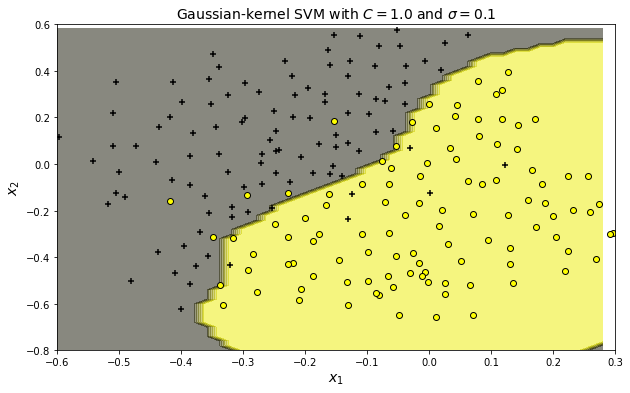

In [93]:
plt.figure()
#cs = plt.contour(xx,yy,z_svc,levels=[0],colors='b',linestyles='-',linewidths=2) # explicitly plot decision boundary
# plt.clabel(cs, fmt = '%2.1d', colors = 'b', fontsize=14) # label decision boundary contour line
csf = plt.contourf(xx,yy,z_svc,cmap=yellow_black,alpha=0.5) # classified feature space
#plt.colorbar(csf)
plt.scatter(X[:,0][y==1],X[:,1][y==1],marker='+',edgecolors='k',facecolor='k')
plt.scatter(X[:,0][y==0],X[:,1][y==0],marker='o',edgecolors='k',facecolor='yellow')
plt.xlim(-0.6,0.3)
plt.ylim(-0.8,0.6)
plt.xlabel(r'$x_1$',fontsize=14)
plt.ylabel(r'$x_2$',fontsize=14)
plt.title(r'Gaussian-kernel SVM with $C={}$ and $\sigma={}$'.format(optimal_C,optimal_sigma),fontsize=14)
plt.show()

# 2. Spam Classification

## 2.1 Preprocessing Emails

## 2.2 Extracting Features from Emails

## 2.3 Training SVM for Spam Classification

## 2.4 Top Predictors for Spam

## 2.5 Optional Exercise: Try Your Own Emails

## 2.6 Optional Exercise: Build Your Own Dataset